# MNIST example 

This notebook shows how to run a pre-trained convolutional network to classify handwritten digits. We will also make some changes to the pre-trained model, and train it again to see it we can improve its performance. 

## Install dependencies

To be able to properly load a saved model, it is important to match the software it was created with. In this case, we have specified it in a `requirements.txt` file. Let us check that it is present, otherwise download it:

In [ ]:
%%bash
if [[ -e requirements.txt ]]; then
    echo "Found requirements.txt"
else
    wget https://raw.githubusercontent.com/smaeland/model-zoo-mnist-example/main/requirements.txt
    echo "Dowloaded requirements.txt"
fi

Great. Now we can install the things we need:

In [ ]:
! pip install -r requirements.txt

And then import the relevant packages:

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

2021-09-02 15:40:58.227154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-02 15:40:58.227171: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Download the data

With the requirements in place, we can download the data we will use, and have a look at some of the images.

Loaded 60000 training samples, 60000 testing samples


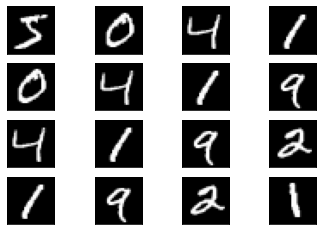

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

num_classes = 10
num_train_samples = x_train.shape[0]
num_test_samples = x_train.shape[0]
print(f'Loaded {num_train_samples} training samples, {num_test_samples} testing samples')

ncols, nrows = 4, 4 
fig, axs = plt.subplots(nrows, ncols, figsize=(6,4))
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(x_train[i+j], cmap='gray')
        axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()


Looks like digits, all right. Let us preprocess the images to have the dimensions and ranges that the model expects. In addition, we convert the labels from a vector (containing 0, 1, ..., 9) to a categorical / one-hot matrix. 

## Download the pre-trained model

# TODO

In [3]:
model = keras.models.load_model('cnn-model-v1')
print(model.summary())

2021-09-02 15:41:09.640849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-02 15:41:09.641412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-02 15:41:09.642050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-02 15:41:09.642087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-09-02 15:41:09.642115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dropout (Dropout)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                77450     
Total params: 96,266
Trainable params: 96,266
Non-trainable params: 0
____________________________________________________

## Preprocess our data and run predictions

A model will typically require a specific way of preprocessing input data, such as scaling. Having done so, we can go ahead and make some predictions, and use them to evaluate performance.

In [4]:
def preprocess(input_data):
        
    # Scale images to the [0, 1] range
    preprocessed_data = input_data.astype("float32") / 255

    # Data has shape (n, height, width), add a channel dimension so it becomes (n, height, width, 1)
    preprocessed_data = np.expand_dims(preprocessed_data, axis=-1)

    return preprocessed_data


x_train = preprocess(x_train)
x_test = preprocess(x_test)

Accuracy: 0.991


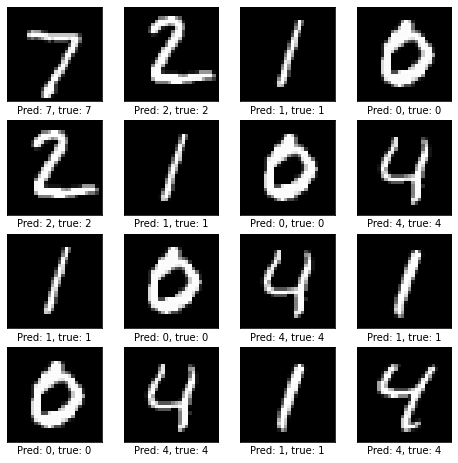

In [6]:
from sklearn.metrics import accuracy_score

preds = model.predict(x_test)

# Preds are one-hot encoded -- convert to vector form
preds = np.argmax(preds, axis=1)

print('Accuracy:', accuracy_score(y_test, preds))


ncols, nrows = 4, 4 
fig, axs = plt.subplots(nrows, ncols, figsize=(8,8))
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(x_test[i+j], cmap='gray')
        axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        axs[i, j].set_xlabel(f'Pred: {preds[i+j]}, true: {y_test[i+j]}')
plt.show()

## Modify and re-train the model

The model is performing great, but we can still try to improve by expanding it. Having inspected the output from `model.summary()` (above), we decide to keep everything up till `conv2d_1`, and add an additional pooling and convolution layer:

In [11]:
base_model_conv2d = model.get_layer('conv2d_1').output
new_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(base_model_conv2d)
new_layer = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_2')(new_layer)
new_layer = keras.layers.Flatten()(new_layer)
new_layer = keras.layers.Dropout(0.5)(new_layer)
new_layer = keras.layers.Dense(num_classes, activation='softmax')(new_layer)

new_model = keras.Model(inputs=model.input, outputs=new_layer)

print(new_model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0   

New layers require re-compiling the model and re-training the new weights. Note that we one-hot encode the targets before training.

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 128
epochs = 10

y_train_onehot = keras.utils.to_categorical(y_train)

model.fit(
    x_train,
    y_train_onehot,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    verbose=2
)

Epoch 1/10
422/422 - 11s - loss: 0.0238 - accuracy: 0.9917 - val_loss: 0.0337 - val_accuracy: 0.9912
Epoch 2/10
422/422 - 11s - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.0328 - val_accuracy: 0.9917
Epoch 3/10
422/422 - 15s - loss: 0.0199 - accuracy: 0.9936 - val_loss: 0.0321 - val_accuracy: 0.9928
Epoch 4/10
422/422 - 14s - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0307 - val_accuracy: 0.9923
Epoch 5/10
422/422 - 14s - loss: 0.0167 - accuracy: 0.9938 - val_loss: 0.0363 - val_accuracy: 0.9917
Epoch 6/10
422/422 - 13s - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0330 - val_accuracy: 0.9920
Epoch 7/10
422/422 - 13s - loss: 0.0151 - accuracy: 0.9949 - val_loss: 0.0364 - val_accuracy: 0.9912
Epoch 8/10
422/422 - 13s - loss: 0.0141 - accuracy: 0.9949 - val_loss: 0.0328 - val_accuracy: 0.9918
Epoch 9/10
422/422 - 13s - loss: 0.0138 - accuracy: 0.9952 - val_loss: 0.0348 - val_accuracy: 0.9925
Epoch 10/10
422/422 - 13s - loss: 0.0122 - accuracy: 0.9957 - val_loss: 0.0335 - val_accura

Now it's time to evaluate the performance of the new model:

In [13]:
new_preds = new_model.predict(x_test)
new_preds = np.argmax(new_preds, axis=1)    # Revert the one-hot encoding before using sklearn metrics

print('Accuracy:', accuracy_score(y_test, new_preds))

Accuracy: 0.0939
